In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs=xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_c']/360 *2*np.pi);
#dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
#print(fs,os)

/net2/smg/documents/OMDT/analysis_CM2p6/grids


In [3]:
%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history
#%ls
u = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_minibling_field_v.nc')['v']
z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

print(thickness)

/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history
<xarray.DataArray 'st_edges_ocean' (st_ocean: 50)>
array([ 10.06709957,  10.09290028,  10.12890053,  10.17849922,
        10.24740219,  10.34269714,  10.47480392,  10.6576004 ,
        10.9101944 ,  11.25960541,  11.74169922,  12.40619659,
        13.32000732,  14.57260132,  16.28289795,  18.604599  ,
        21.73239136,  25.90260315,  31.3868103 ,  38.4697876 ,
        47.40710449,  58.35928345,  71.30871582,  85.9883728 ,
       101.85479736, 118.14520264, 134.01159668, 148.69128418,
       161.64074707, 172.59289551, 181.53027344, 188.61315918,
       194.09741211, 198.26745605, 201.39550781, 203.71704102,
       205.42749023, 206.67993164, 207.59399414, 208.25805664,
       208.74047852, 209.08984375, 209.34228516, 209.52539062,
       209.65722656, 209.75244141, 209.82177734, 209.87109375,
       209.90673828, 209.93310547])
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03


In [4]:
KE = 0.5*(u[-1,0,:,:]**2 + v[-1,0,:,:]**2)
print(KE)
#u_BT = u.mean('time')

<xarray.DataArray (yu_ocean: 2700, xu_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    st_ocean  float64 5.034
    time      object 0202-12-29 12:00:00


In [5]:
%%time
u_ts= u[-1,:,:,:]
v_ts= v[-1,:,:,:]
mask = u[-1,:,:,:]*0.0+1.
thickness_test = mask*thickness

u_BT = (u_ts*thickness_test/thickness_test.sum('st_ocean')).sum('st_ocean')
v_BT = (v_ts*thickness_test/thickness_test.sum('st_ocean')).sum('st_ocean')
print('done')
u_BC = u_ts-u_BT
v_BC = v_ts-v_BT
print(u_BT.shape,v_BT.shape)

done
(2700, 3600) (2700, 3600)
CPU times: user 1min 12s, sys: 35.7 s, total: 1min 48s
Wall time: 1min 48s


In [6]:
%%time
mask_2D = KE*0.+1.

KE_BT = 0.5*(u_BT**2+v_BT**2)*mask_2D
KE_BC = ((0.5*(u_BC**2+v_BC**2)*thickness_test/thickness_test.sum('st_ocean')).sum('st_ocean'))*mask_2D

CPU times: user 31.6 s, sys: 12.3 s, total: 44 s
Wall time: 44.1 s


In [7]:
print(KE_BT.shape)
print(KE_BC.shape)

(2700, 3600)
(2700, 3600)


In [16]:
KE_BT

<xarray.DataArray (yu_ocean: 2700, xu_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    time      object 0202-12-29 12:00:00
    st_ocean  float64 5.034

In [17]:
from pylab import *
from numpy import *
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels-self.levels.min()
        self._x/= self._x.max()
        self._y = linspace(0, 1, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

CPU times: user 8min 30s, sys: 5.03 s, total: 8min 35s
Wall time: 8min 35s


Text(0.5, 1.0, 'BT KE, 1/10$^\\circ$ CM2.6')

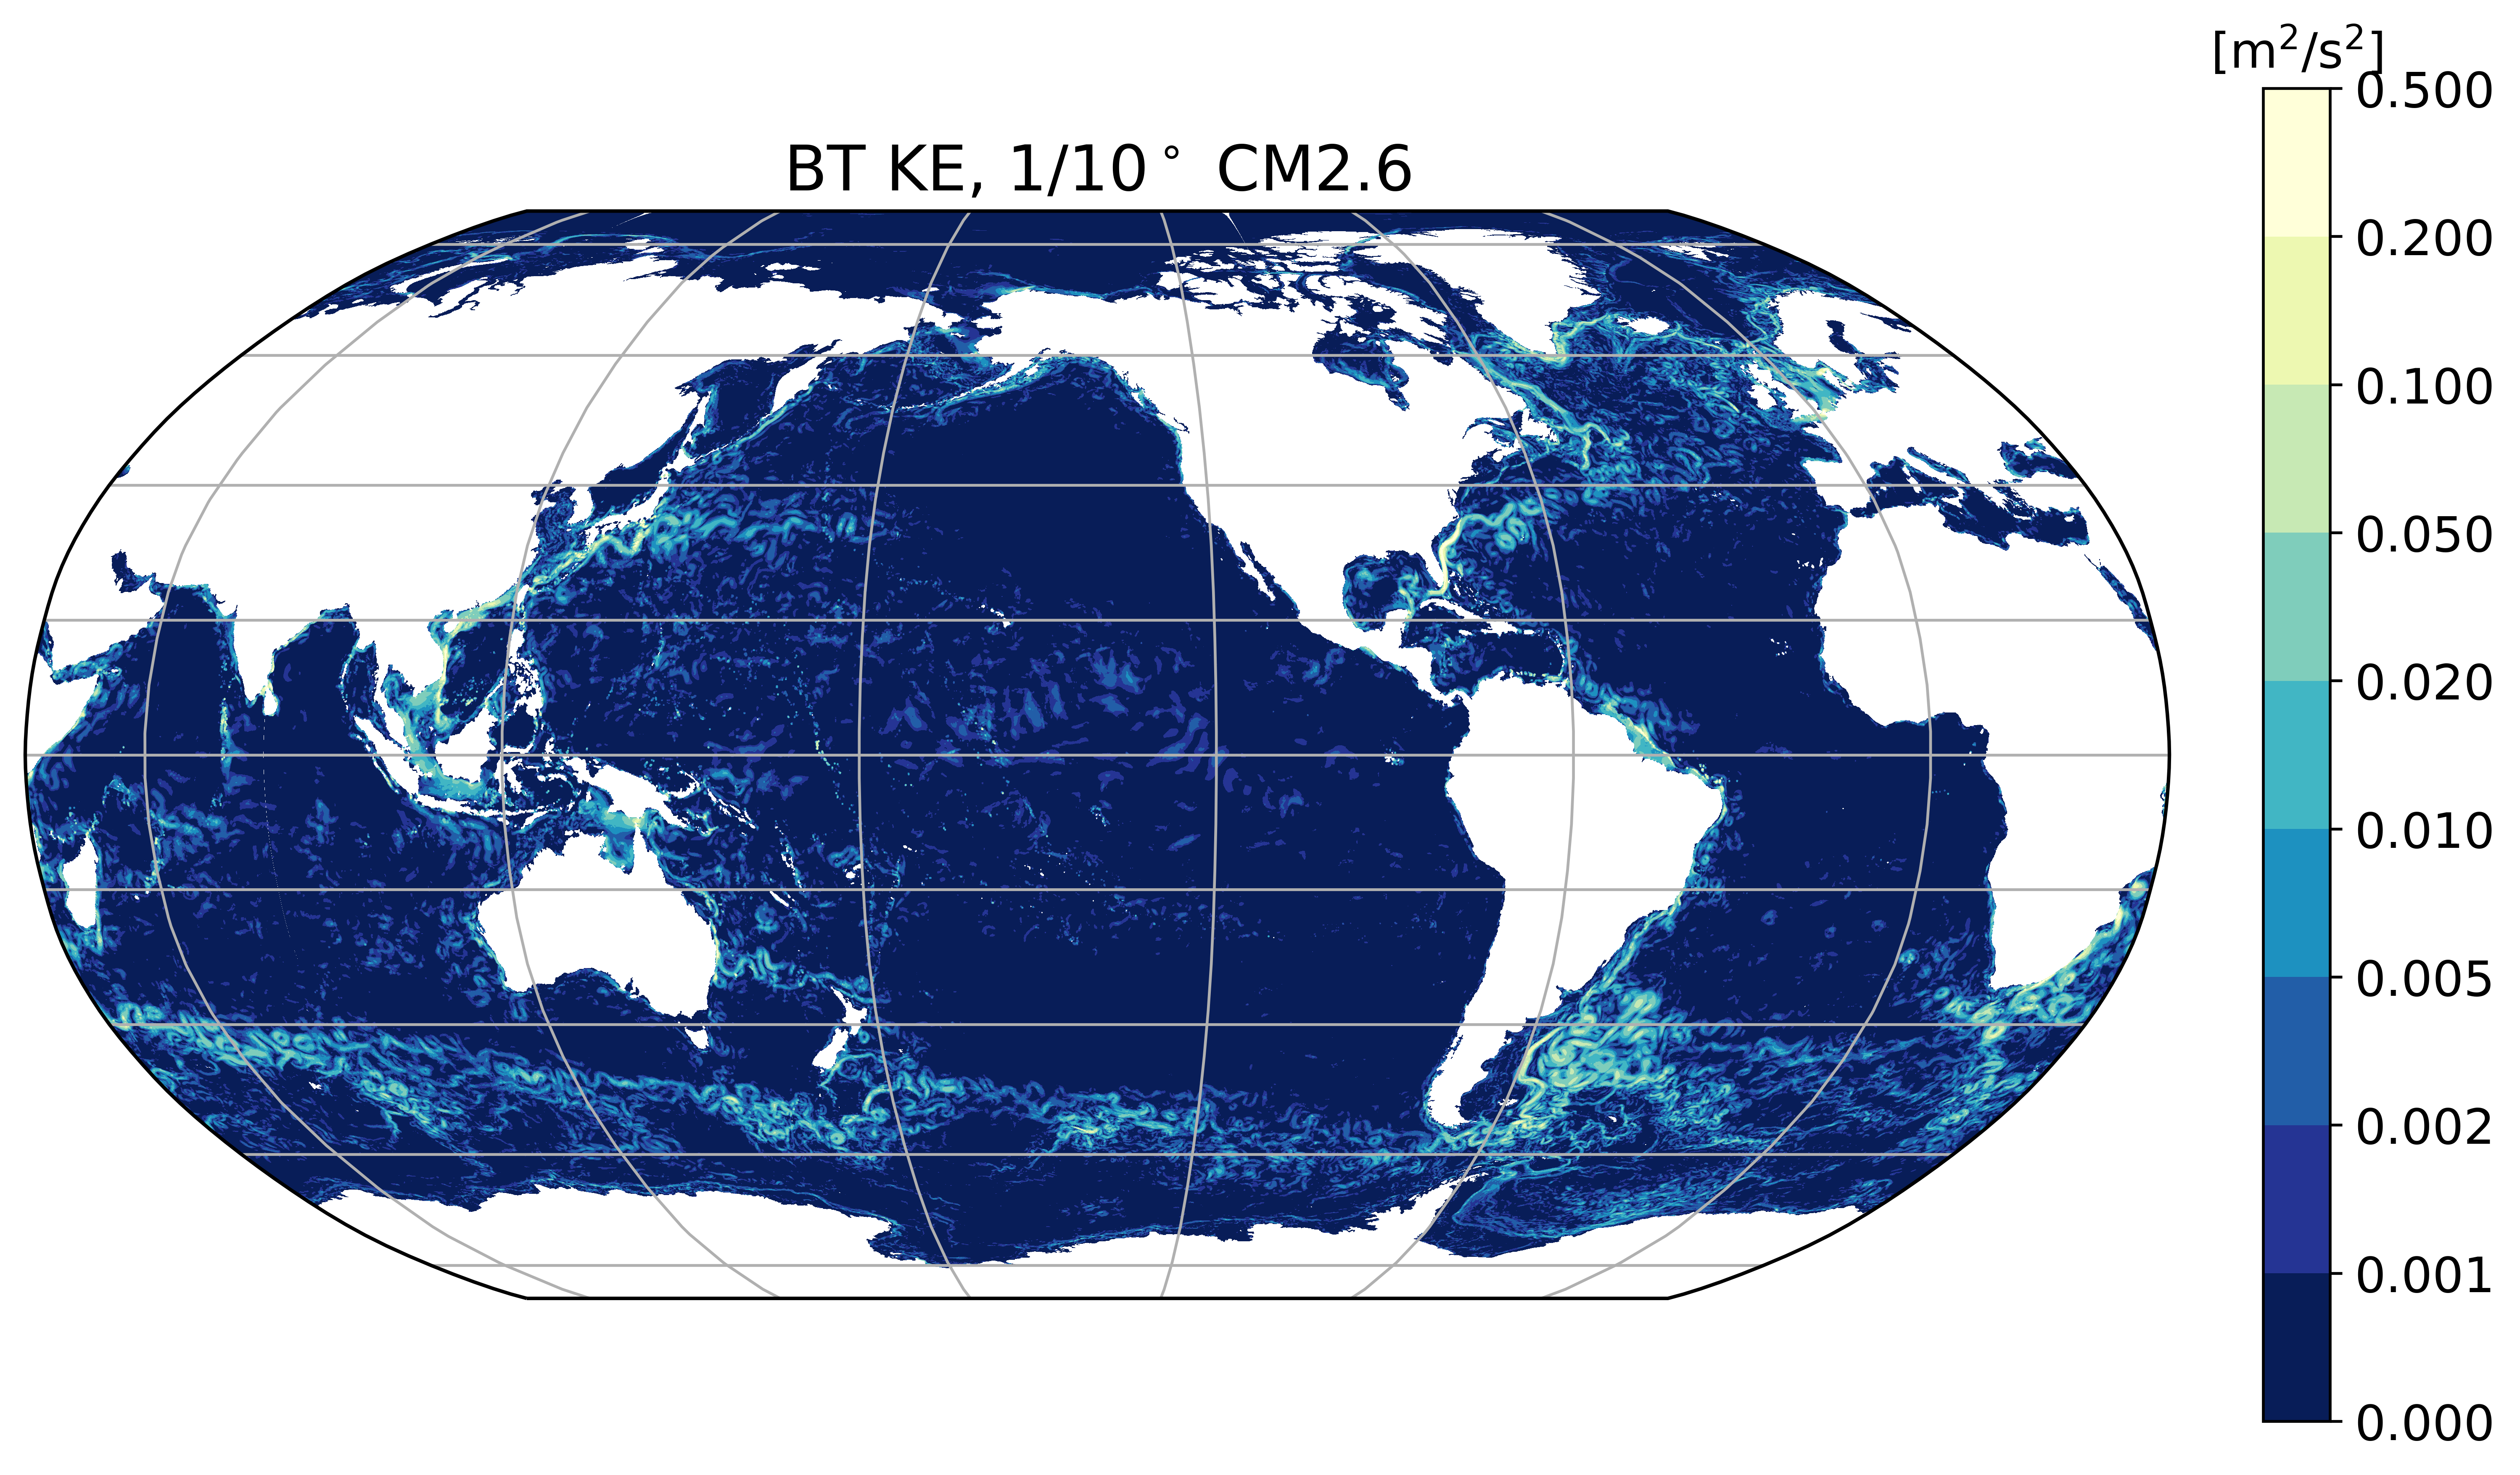

In [62]:
%%time
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=-140))

cmap_lin = plt.get_cmap('YlGnBu_r', 9)
ticklevel=[0.000,0.001,0.002,0.005,0.010,0.020,0.050,0.100,0.200,0.500]
cmap_nonlin = nlcmap(cmap_lin, ticklevel)

#plt.contourf(lon, lat, lon[*0+1.,transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1.2);

plot1=plt.contourf(lon.values,lat.values,(KE_BT).values,ticklevel,transform=ccrs.PlateCarree(),cmap=cmap_nonlin);
#plot1=plt.pcolormesh(lon.values,lat.values,KE.fillna(0.).values,transform=ccrs.PlateCarree(),cmap=cmocean.cm.deep,vmin=0.0,vmax=0.01);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m$^2$/s$^2$]', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('BT KE, 1/10$^\circ$ CM2.6',fontsize=18) #positive into ocean


CPU times: user 6min 12s, sys: 3.59 s, total: 6min 15s
Wall time: 6min 15s


Text(0.5, 1.0, 'BC KE, 1/10$^\\circ$ CM2.6')

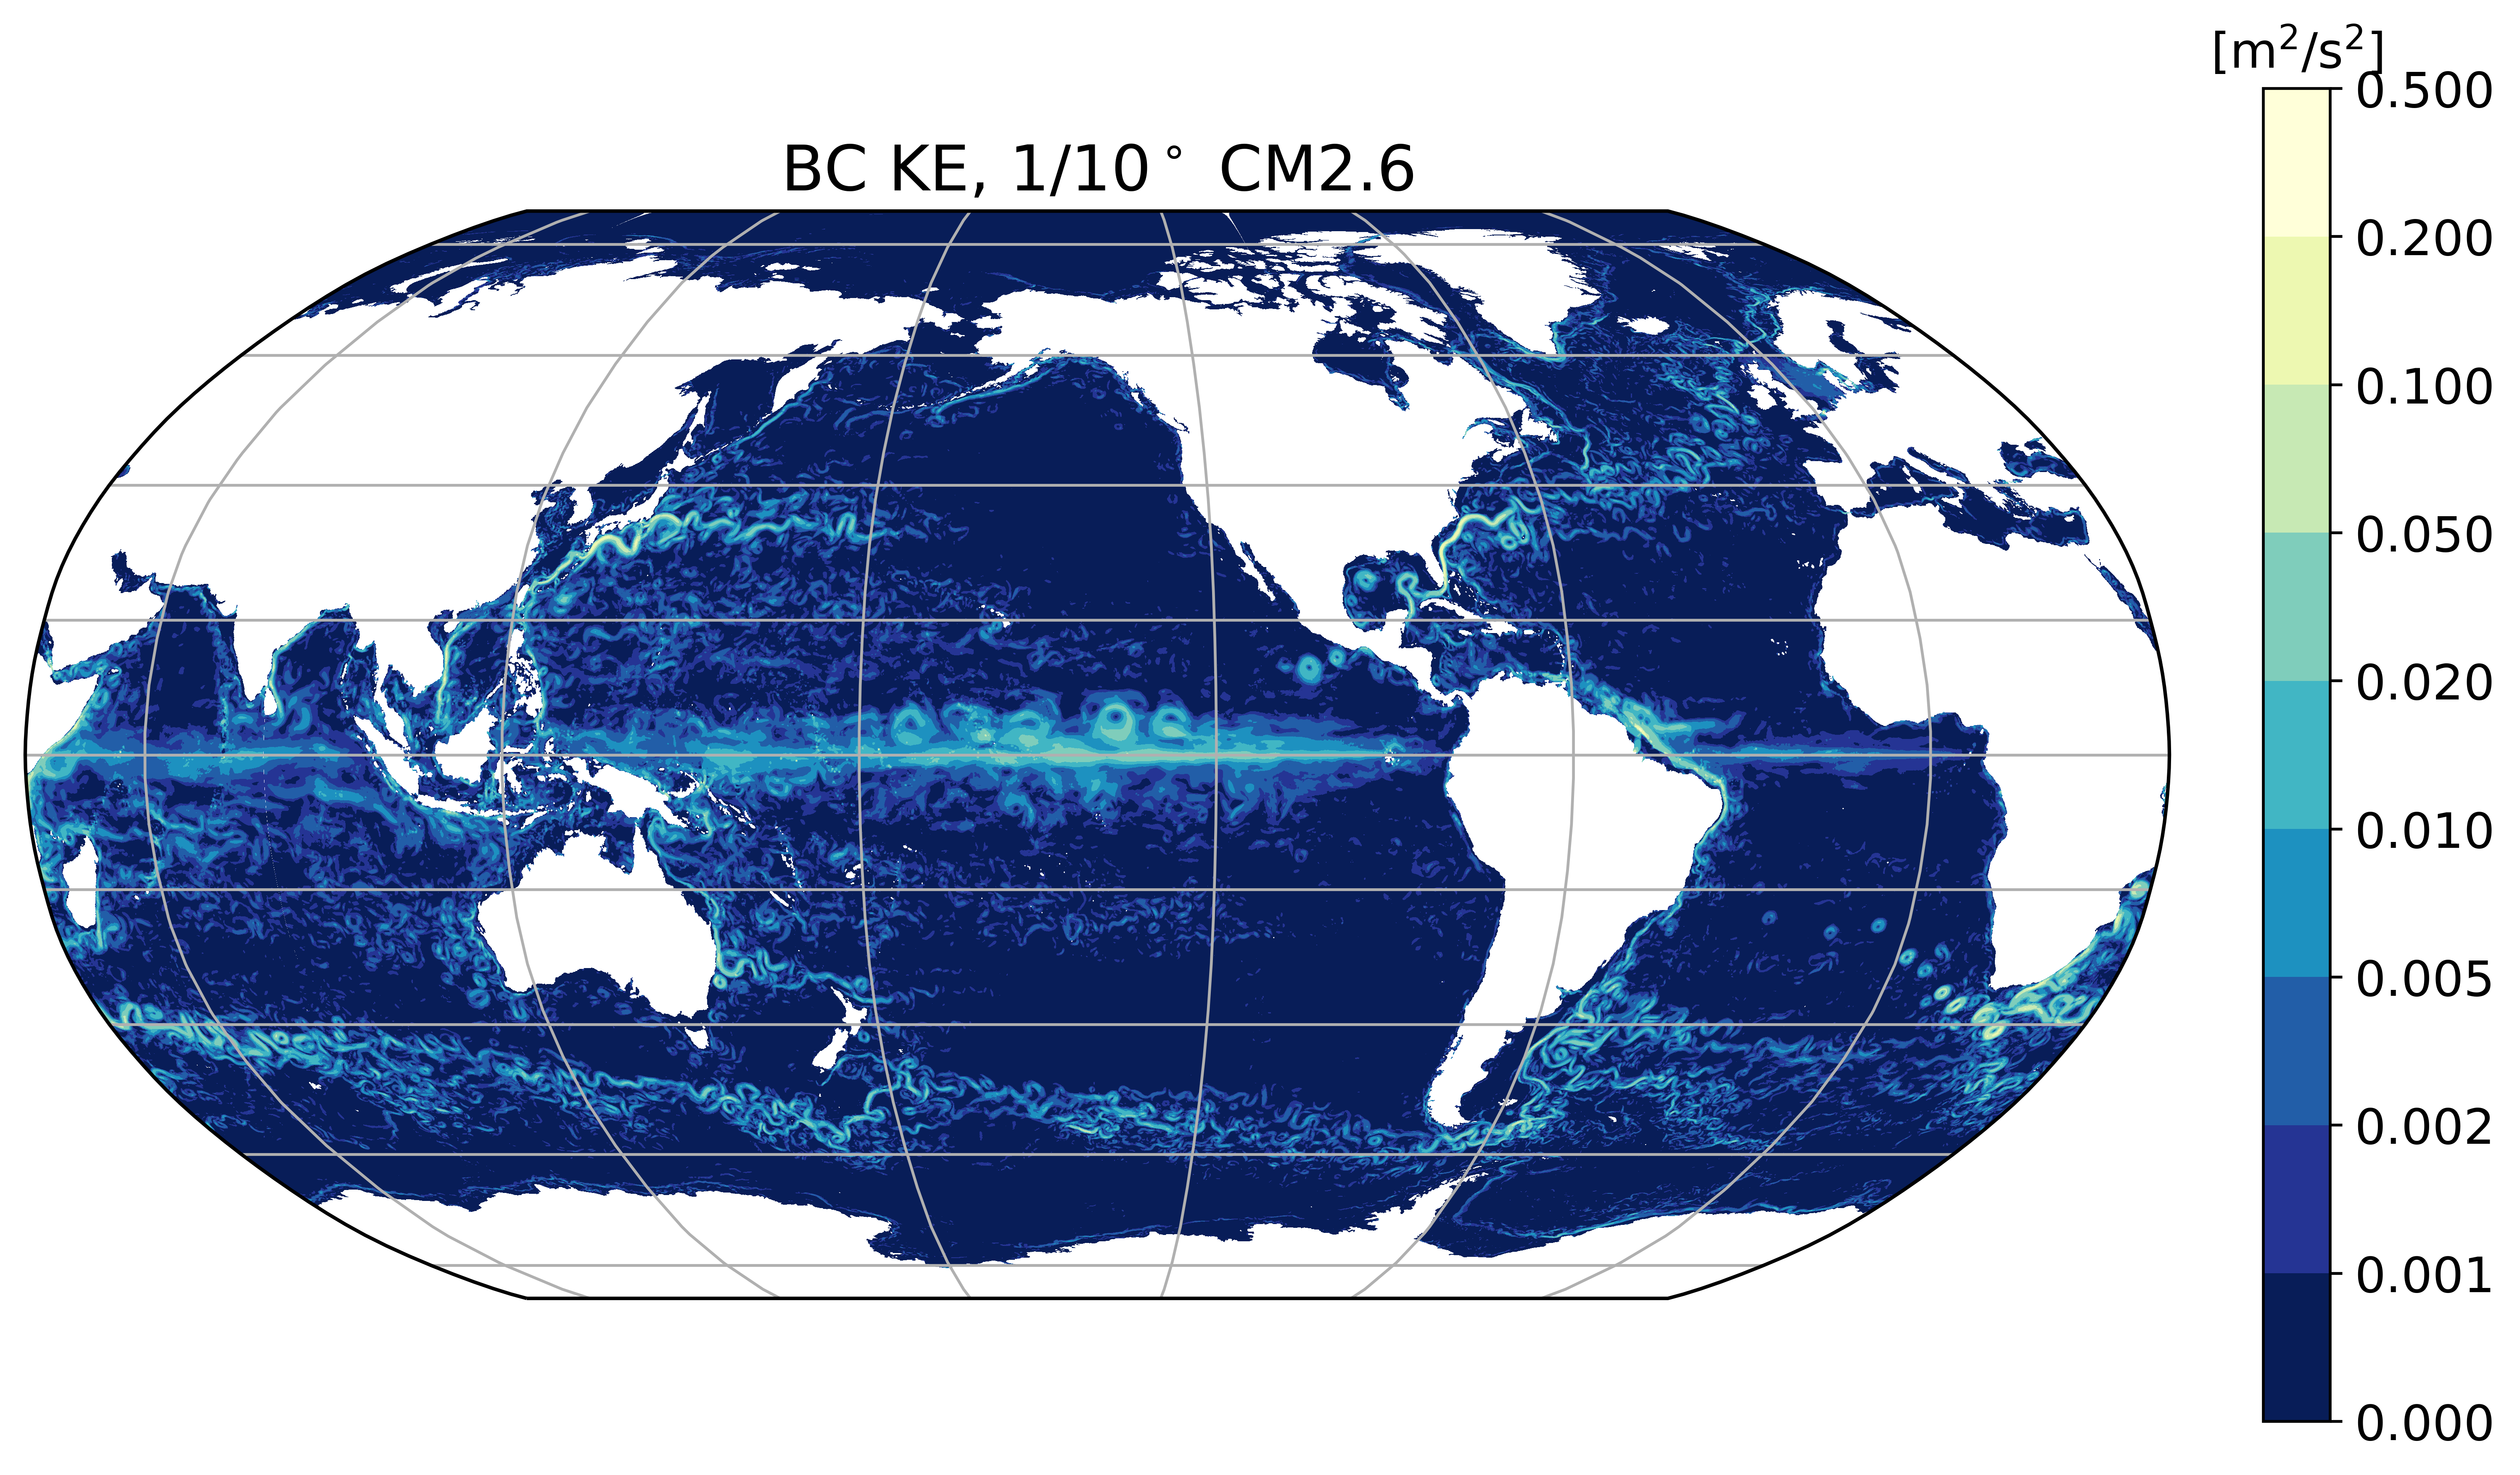

In [63]:
%%time
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=-140))

cmap_lin = plt.get_cmap('YlGnBu_r', 9)
ticklevel=[0.000,0.001,0.002,0.005,0.010,0.020,0.050,0.100,0.200,0.500]
cmap_nonlin = nlcmap(cmap_lin, ticklevel)

#plt.contourf(lon, lat, lon[*0+1.,transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1.2);

plot1=plt.contourf(lon.values,lat.values,(KE_BC).values,ticklevel,transform=ccrs.PlateCarree(),cmap=cmap_nonlin);
#plot1=plt.pcolormesh(lon.values,lat.values,KE.fillna(0.).values,transform=ccrs.PlateCarree(),cmap=cmocean.cm.deep,vmin=0.0,vmax=0.01);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m$^2$/s$^2$]', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('BC KE, 1/10$^\circ$ CM2.6',fontsize=18) #positive into ocean


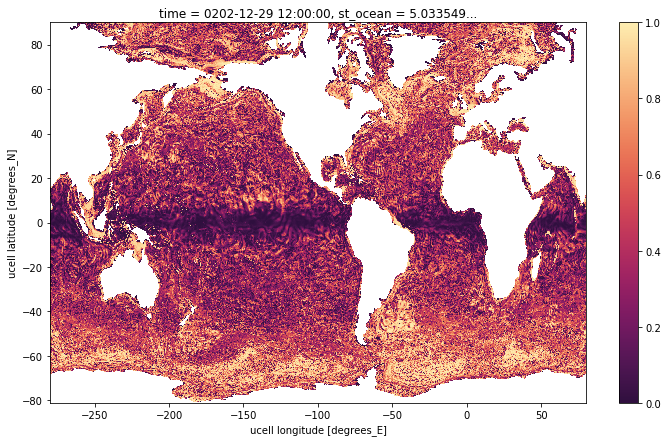

In [34]:
fraction_BT = (KE_BT/(KE_BC+KE_BT))
fraction_BC = (KE_BC/(KE_BC+KE_BT))
fraction_BT.plot(figsize=(12, 7),cmap=cmocean.cm.matter_r,vmin=0,vmax=1)

In [25]:
%%time
#fig = plt.figure()
fig = plt.figure(figsize=(12, 7), dpi= 300, facecolor='w', edgecolor='k')

ax = plt.subplot(projection=ccrs.Robinson(central_longitude=-140))

ticklevel=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0];


plot1=plt.contourf(lon.values,lat.values,fraction_BT.values,ticklevel,transform=ccrs.PlateCarree(),cmap=cmocean.cm.matter_r);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m$^2$/s$^2$]', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('BT KE Fraction, 1/10$^\circ$ CM2.6',fontsize=18) #positive into ocean

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2ab4fda889e0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2ab4d6bc23b0> (for post_execute):


KeyboardInterrupt: 

In [31]:
zonal_BT = fraction_BT.mean('xu_ocean')
zonal_BC = fraction_BC.mean('xu_ocean')

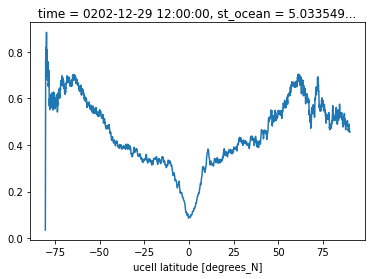

In [32]:
zonal_BT.plot()